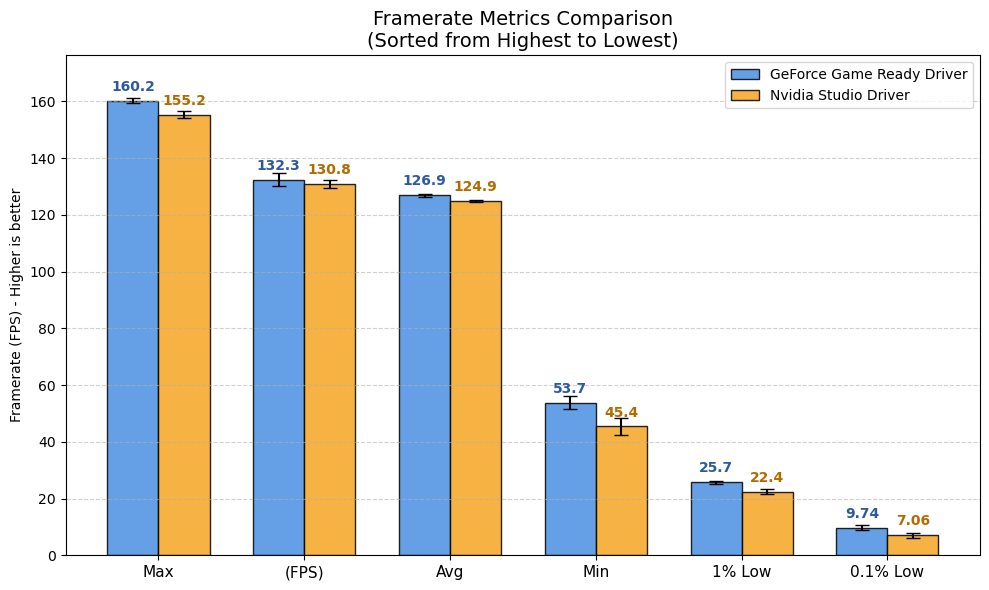

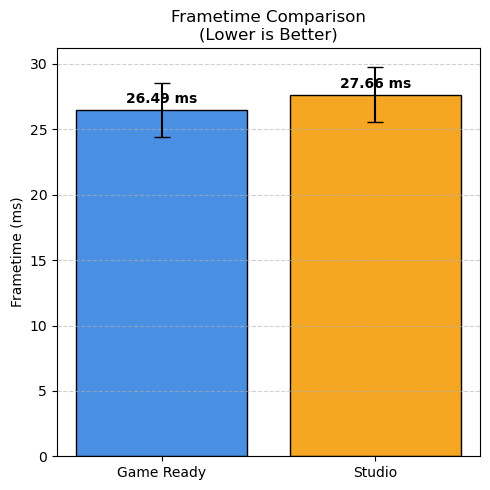

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# --- โหลดข้อมูล ---
df_gr = pd.read_csv("game_ready_baseline_test.csv")
df_st = pd.read_csv("studio_baseline_test.csv")

df_gr.set_index('Column', inplace=True)
df_st.set_index('Column', inplace=True)

# --- ฟังก์ชันดึง CI half-width ---
def extract_ci_half(ci_str):
    match = re.search(r'±\s*([0-9]*\.?[0-9]+)', str(ci_str))
    return float(match.group(1)) if match else 0.0

# --- เมตริก FPS เท่านั้น (ไม่รวม Frametime) ---
fps_metrics = [
    'Framerate Max (FPS)',
    'Framerate Avg (FPS)',
    'Framerate (FPS)',
    'Framerate Min (FPS)',
    'Framerate 1% Low (FPS)',
    'Framerate 0.1% Low (FPS)'
]

# เรียงตามค่า Mean ของ Game Ready จากมากไปน้อย
means_for_sorting = [df_gr.loc[m, 'Mean'] for m in fps_metrics]
sorted_pairs = sorted(zip(fps_metrics, means_for_sorting), key=lambda x: x[1], reverse=True)
sorted_metrics = [m for m, _ in sorted_pairs]

# --- ดึงข้อมูล ---
means_gr = [df_gr.loc[m, 'Mean'] for m in sorted_metrics]
cis_gr   = [extract_ci_half(df_gr.loc[m, 'CI']) for m in sorted_metrics]

means_st = [df_st.loc[m, 'Mean'] for m in sorted_metrics]
cis_st   = [extract_ci_half(df_st.loc[m, 'CI']) for m in sorted_metrics]

# --- สร้างกราฟ ---
x = np.arange(len(sorted_metrics))
width = 0.35

plt.figure(figsize=(10, 6))

bars_gr = plt.bar(x - width/2, means_gr, width, yerr=cis_gr, capsize=5,
                  label='GeForce Game Ready Driver', color='#4A90E2', edgecolor='black', alpha=0.85)
bars_st = plt.bar(x + width/2, means_st, width, yerr=cis_st, capsize=5,
                  label='Nvidia Studio Driver', color='#F5A623', edgecolor='black', alpha=0.85)

# ใส่ค่าบนแท่ง
max_val = max(max(means_gr), max(means_st))
for bar, mean in zip(bars_gr, means_gr):
    val = f'{mean:.1f}' if mean >= 10 else f'{mean:.2f}'
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max_val * 0.015,
             val, ha='center', va='bottom', fontweight='bold', color='#2C5AA0')

for bar, mean in zip(bars_st, means_st):
    val = f'{mean:.1f}' if mean >= 10 else f'{mean:.2f}'
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max_val * 0.015,
             val, ha='center', va='bottom', fontweight='bold', color='#B36B00')

# ตั้งชื่อแกน
short_labels = [m.replace('Framerate ', '').replace(' (FPS)', '') for m in sorted_metrics]
plt.xticks(x, short_labels, fontsize=11)

plt.ylabel('Framerate (FPS) - Higher is better')
plt.title('Framerate Metrics Comparison\n(Sorted from Highest to Lowest)', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.ylim(0, max_val * 1.1)
plt.tight_layout()
plt.show()

# --- แสดง Frametime แยกเป็นกราฟเดียว ---
frametime_gr = df_gr.loc['Frametime (ms)', 'Mean']
frametime_st = df_st.loc['Frametime (ms)', 'Mean']
ci_gr_ft = extract_ci_half(df_gr.loc['Frametime (ms)', 'CI'])
ci_st_ft = extract_ci_half(df_st.loc['Frametime (ms)', 'CI'])

plt.figure(figsize=(5, 5))
bars = plt.bar(['Game Ready', 'Studio'], [frametime_gr, frametime_st],
               yerr=[[ci_gr_ft], [ci_st_ft]], capsize=6,
               color=['#4A90E2', '#F5A623'], edgecolor='black')
for bar, val in zip(bars, [frametime_gr, frametime_st]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f'{val:.2f} ms', ha='center', va='bottom', fontweight='bold')
plt.ylabel('Frametime (ms)')
plt.title('Frametime Comparison\n(Lower is Better)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()